<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/3_submit_test/hj-submit_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tutorial/3_submit_test/hj-submit_test.ipynb

# Submit Test

Test Set은 30일에 3번만 제출 가능하지만, Validation Set은 무제한으로 제출 가능하다. Validationo Set으로 Submit Test 해보려고 한다.

아래 명령은 Google Storage에 있는 Waymo Open Dataset을 구글 드라이브로 다운받는 명령어다. Validation Set만 약 74GB이므로 유료 결제한 재승이 구글 드라이브에 올리고 공유해서 사용해보려고 한다.
```
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
drive.mount('/content/drive', force_remount=True)

!gsutil -m cp -r \
  "gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/tf_example/validation" \
  /content/drive/MyDrive/WaymoDataset/Validation/
```

## 구글 드라이브 연동

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
VALIDATION_PATH = "/content/drive/MyDrive/waymo-od-dataset/motion_v_1_2_0/uncompressed/scenario/validation/"

## Package Installaion

In [ ]:
%%capture
!pip3 install --upgrade pip
!pip install waymo-open-dataset-tf-2-11-0==1.5.1 # 최신 버전 라이브러리

## Imports and global definitions

In [ ]:
import math
import os
import uuid
import time

import numpy as np
import tensorflow as tf

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2

In [ ]:
file_paths = tf.io.gfile.glob(VALIDATION_PATH + "*.tfrecord*")

## Load motion prediction dataset

In [ ]:
from waymo_open_dataset.protos import scenario_pb2 

dataset = tf.data.TFRecordDataset(file_paths, compression_type='')
for data in dataset :
   scenario = scenario_pb2.Scenario()
   scenario.ParseFromString(data.numpy())
   break

## 제출 형태 작성

MotionChallengeSubmission 구조
```javascript
message MotionChallengeSubmission {
  enum SubmissionType {
    UNKNOWN = 0;

    // A submission for the Waymo open dataset motion prediction challenge.
    MOTION_PREDICTION = 1;

    // A submission for the Waymo open dataset interaction prediction challenge.
    INTERACTION_PREDICTION = 2;
  }

  // This must be set as the full email used to register at waymo.com/open.
  optional string account_name = 3;

  // This name needs to be short, descriptive and unique. Only the latest result
  // of the method from a user will show up on the leaderboard.
  optional string unique_method_name = 4;

  // Author information.
  repeated string authors = 5;
  optional string affiliation = 6;

  // A brief description of the method.
  optional string description = 7;

  // Link to paper or other link that describes the method.
  optional string method_link = 8;

  // The challenge submission type.
  optional SubmissionType submission_type = 2;

  // Set this to true if your model uses the lidar data provided in the motion
  // dataset.
  optional bool uses_lidar_data = 9;

  // The set of scenario predictions to evaluate. One entry should exist for
  // every record in the test set.
  repeated ChallengeScenarioPredictions scenario_predictions = 1;
}
```

In [ ]:
from waymo_open_dataset.protos import motion_submission_pb2

submission = motion_submission_pb2.MotionChallengeSubmission()

submission.account_name = 'hyocurity@gmail.com'
submission.unique_method_name = 'HJNet'
submission.authors.append('Hyojin Lee')
submission.authors.append('Jaeseung Lee')
submission.affiliation = 'RO:AD'
submission.description = "Validation Set Test"
submission.method_link = 'NA'
submission.submission_type = submission.MOTION_PREDICTION
submission.uses_lidar_data = False

submission

submission_type: MOTION_PREDICTION
account_name: "hyocurity@gmail.com"
unique_method_name: "HJNet"
authors: "Hyojin Lee"
authors: "Jaeseung Lee"
affiliation: "RO:AD"
description: "Validation Set Test"
method_link: "NA"
uses_lidar_data: false

In [ ]:
from waymo_open_dataset.protos import scenario_pb2

cnt = 1
for data in dataset :
  if cnt % 10000 == 0:
    print(f"** Scenario {cnt}")
  cnt += 1
  
  scenario = scenario_pb2.Scenario()
  scenario.ParseFromString(bytearray(data.numpy()))

  if len(scenario.tracks_to_predict) == 0:
    continue

  scenario_preds = motion_submission_pb2.ChallengeScenarioPredictions()
  scenario_preds.scenario_id = scenario.scenario_id

  for ttp in scenario.tracks_to_predict:
    track = scenario.tracks[ttp.track_index]
    prediction = motion_submission_pb2.SingleObjectPrediction()
    prediction.object_id = track.id

    scored_trajectory = motion_submission_pb2.ScoredTrajectory()

    # 예측해야하는 답안. future. 8초간 0.5초씩 총 16개의 (x,y)를 예측
    # 시작 지점은 15번째부터.
    future_states = track.states[15::5]
    for state in future_states:
      scored_trajectory.trajectory.center_x.append(state.center_x)
      scored_trajectory.trajectory.center_y.append(state.center_y)
    prediction.trajectories.append(scored_trajectory)

    scenario_preds.single_predictions.predictions.append(prediction)

  submission.scenario_predictions.append(scenario_preds) # submission에 추가하기

print(f"** Scenario {cnt}")

** Scenario 10000
** Scenario 20000
** Scenario 30000
** Scenario 40000
** Scenario 44098


- tracks_to_predict에 해당하는 tracks만 입력했다. 15번째 인덱스(1.5초)부터 0.5초 간격으로 결과값을 입력하면 된다.
- 실행 시간은 25분 정도 걸린다.

In [ ]:
import tarfile
from time import time
import io
from google.colab import files

timestamp = str(time()).split('.')[0]
fname = f'{timestamp}-motion-pred-submission.tar.gz'

# submission 파일의 형태는 bin이지만, tarball(tar.gz)로 압축해서 제출해야 함.
with tarfile.open(fname, "w:gz") as tar:
    f = io.BytesIO(submission.SerializeToString())
    info = tarfile.TarInfo(name=fname)
    info.size = len(f.getvalue())
    tar.addfile(tarinfo=info, fileobj=f)

files.download(fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- 제출했을 때 채점이 15분 정도 걸린다.

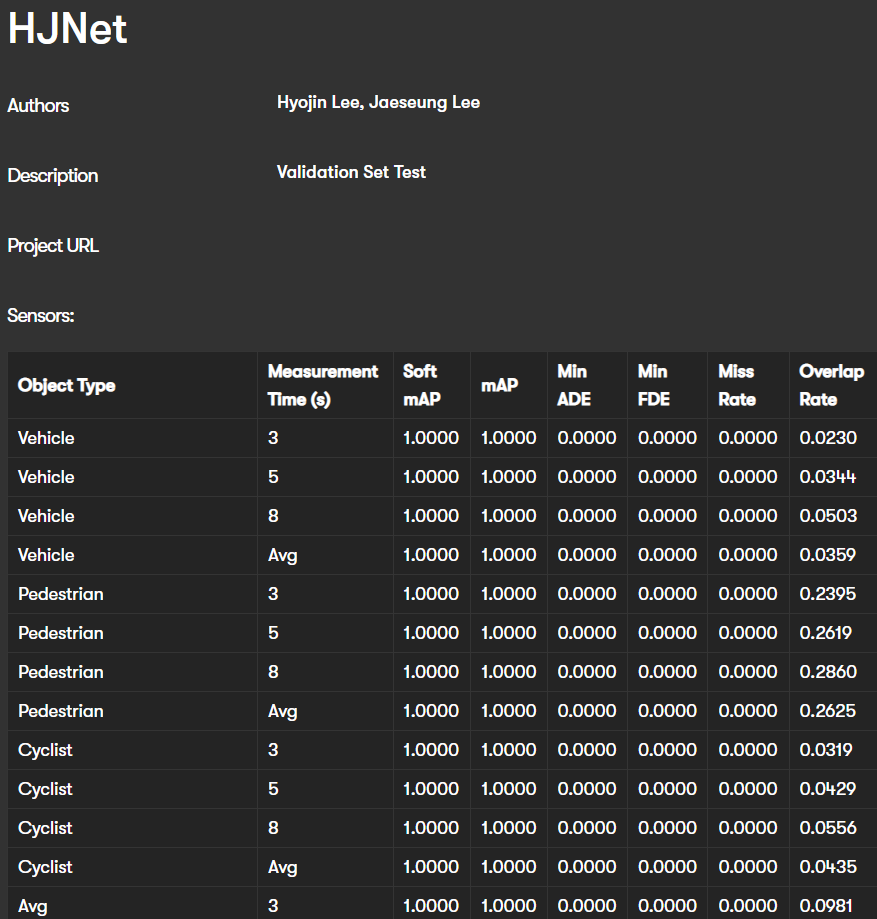